In [1]:
from tensorflow.keras.layers import  Dense, Dropout, Flatten, Input, Reshape, Conv1D, Activation,BatchNormalization, MaxPooling1D,LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import scipy.io
import pandas as pd
from scipy import signal
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')

C:\Users\EE\anaconda3\envs\nabeel\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\EE\anaconda3\envs\nabeel\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\EE\anaconda3\envs\nabeel\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
#Declaring the variables
BATCH_SIZE=25
EPOCHS=100
INPUT_SIZE=512;
BASE_DIR='C:/Users/EE/Documents/Python Scripts/CorNet_Dalia'
DATA_DIR='C:/Users/EE/Documents/MATLAB/PPG_Dalia/datadalia'
SUBJECTS=['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','S15']
Data_files=[]
Filt_datafiles=[]
for i in range(len(SUBJECTS)):
    Data_files.append(DATA_DIR+'/'+SUBJECTS[i]+'/'+SUBJECTS[i]+'.mat')
    Filt_datafiles.append(DATA_DIR+'/'+SUBJECTS[i]+'/'+SUBJECTS[i]+'_filt.mat')

In [3]:
def Core_net():    
    i=Input(shape=(INPUT_SIZE,1),name="input")
    m=Conv1D(32,kernel_size=40)(i)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    m=Conv1D(32,kernel_size=40)(m)
    m=BatchNormalization()(m)
    m=Activation('relu')(m)
    m=MaxPooling1D(pool_size=4)(m)
    m=Dropout(0.1)(m)
    #m=Flatten()(m)
    m=LSTM(128, activation='tanh',return_sequences=True)(m)
    m=LSTM(128, activation='tanh')(m)
    m=Dense(1)(m)
    newmodel = Model(inputs=i,outputs=m)
    return newmodel

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 473, 32)           1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 473, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 473, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 118, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79, 32)           

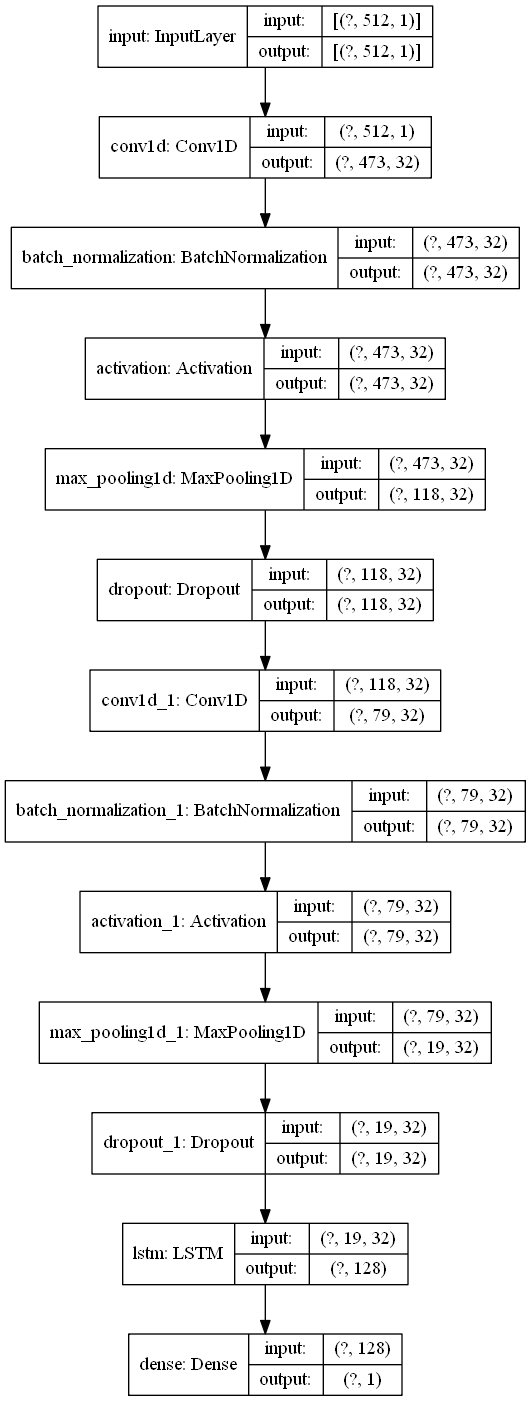

In [4]:
corenet=Core_net()
corenet.summary()
plot_model(corenet,show_shapes=True)

In [5]:
def get_callbacks(name_weights):
    mcp_save = ModelCheckpoint(name_weights+"_weights.hdf5", save_best_only=True, monitor='val_loss', mode='min')
    csv_log=CSVLogger(name_weights+'.csv',separator=',')
    return [mcp_save, csv_log]

In [6]:
def Get_Data():
    for d in range(len(Data_files)):
        mat = scipy.io.loadmat(Filt_datafiles[d])
        mattrue=scipy.io.loadmat(Data_files[d])
        PPG_BPM=mattrue['data']['label'][0][0][0]
        PPG_Subject=np.array(mat['PPG_filt'])

        #PPG_Train,PPG_True,Loo_Train,Loo_True=get_Tdata(PPG,PPG_True_1,0)
        #print((np.reshape(PPG_Train,(PPG_Train.shape[0],1000,1))).shape)
        if d==0:
            PPG_Data=np.reshape(PPG_Subject,(PPG_Subject.shape[0],INPUT_SIZE,1))
            PPG_TrueBPM=PPG_BPM
            #Loo_Train_data= np.reshape(Loo_Train,(1,INPUT_SIZE,1))
            #Loo_True_val=Loo_True
        else:
            PPG_Data=np.concatenate((PPG_Data,np.reshape(PPG_Subject,(PPG_Subject.shape[0],INPUT_SIZE,1))))
            PPG_TrueBPM=np.concatenate((PPG_TrueBPM,PPG_BPM))
            #Loo_Train_data= np.concatenate((Loo_Train_data,np.reshape(Loo_Train,(1,1000,1))))
            #Loo_True_val=np.concatenate((Loo_True_val,Loo_True))
    return (PPG_Data,PPG_TrueBPM)

In [7]:
PPG_Data, TrueBPM=Get_Data()
Train_data, Test_data, Train_label, Test_label = train_test_split(PPG_Data,TrueBPM,test_size=0.10,shuffle=True)

In [8]:
gen_corenet=Core_net()
change="complete"
gen_corenet.compile(optimizer='RMSprop', loss='mean_absolute_error', metrics=['mse','mape'])
weight_dir=BASE_DIR+'/GenModel/'
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
name_weights = weight_dir+"GenModel"+change

In [9]:
callbacks = get_callbacks(name_weights)
history=gen_corenet.fit(Train_data,Train_label, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(Test_data,Test_label),callbacks=callbacks,use_multiprocessing=False)

Epoch 1/100
2330/2330 [==============================] - 9s 4ms/step - loss: 17.0758 - mse: 783.7459 - mape: 17.8379 - val_loss: 7.0947 - val_mse: 142.3149 - val_mape: 7.8477
Epoch 2/100
2330/2330 [==============================] - 9s 4ms/step - loss: 7.0636 - mse: 160.9186 - mape: 7.5818 - val_loss: 5.8664 - val_mse: 115.3155 - val_mape: 6.6038
Epoch 3/100
2330/2330 [==============================] - 9s 4ms/step - loss: 6.2676 - mse: 137.8651 - mape: 6.8159 - val_loss: 6.6446 - val_mse: 145.7302 - val_mape: 7.6841
Epoch 4/100
2330/2330 [==============================] - 9s 4ms/step - loss: 5.9101 - mse: 128.8772 - mape: 6.4770 - val_loss: 5.6617 - val_mse: 120.8301 - val_mape: 6.1079
Epoch 5/100
2330/2330 [==============================] - 9s 4ms/step - loss: 5.6849 - mse: 121.4817 - mape: 6.2407 - val_loss: 5.4070 - val_mse: 109.1660 - val_mape: 5.8181
Epoch 6/100
2330/2330 [==============================] - 9s 4ms/step - loss: 5.4945 - mse: 115.1165 - mape: 6.0326 - val_loss: 5.3303

Epoch 96/100
2330/2330 [==============================] - 13s 6ms/step - loss: 3.4301 - mse: 49.3312 - mape: 3.8626 - val_loss: 4.1876 - val_mse: 81.7734 - val_mape: 4.6567
Epoch 97/100
2330/2330 [==============================] - 16s 7ms/step - loss: 3.3824 - mse: 47.0502 - mape: 3.8156 - val_loss: 4.1919 - val_mse: 79.7397 - val_mape: 4.7203
Epoch 98/100
2330/2330 [==============================] - 13s 6ms/step - loss: 3.4058 - mse: 48.5212 - mape: 3.8409 - val_loss: 4.3497 - val_mse: 83.7957 - val_mape: 5.0401
Epoch 99/100
2330/2330 [==============================] - 16s 7ms/step - loss: 3.3676 - mse: 45.7911 - mape: 3.7915 - val_loss: 4.3378 - val_mse: 84.5445 - val_mape: 4.9933
Epoch 100/100
2330/2330 [==============================] - 14s 6ms/step - loss: 3.3768 - mse: 47.3479 - mape: 3.8098 - val_loss: 4.2492 - val_mse: 86.4861 - val_mape: 4.8434


In [10]:
def plotHistory(histories, name, metric):
    plt.clf() 
    x_axis = list(range(EPOCHS))
    plt.plot(x_axis, histories.history[metric], label=metric+'_'+name)
    plt.scatter(x_axis, histories.history[metric])
    #for hist, name in zip(histories, names):
    #    plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
    #    plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

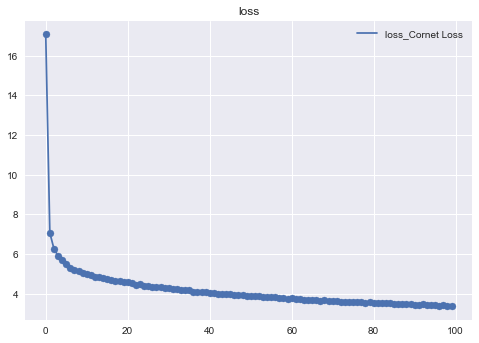

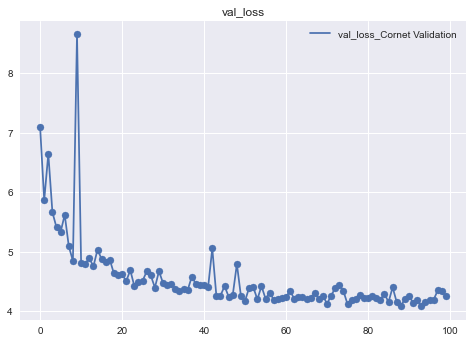

In [11]:
plotHistory(history,'Cornet Loss','loss')
plotHistory(history,'Cornet Validation','val_loss')

In [12]:
StatList=[]
BPM_dir=BASE_DIR+'/Estimated_gen/'
if not os.path.exists(BPM_dir):
    os.mkdir(BPM_dir)
for d in range(len(Data_files)):
    mat = scipy.io.loadmat(Filt_datafiles[d])
    mattrue=scipy.io.loadmat(Data_files[d])
    PPG_BPM=mattrue['data']['label'][0][0][0]
    PPG_Subject=np.array(mat['PPG_filt'])
    preds=gen_corenet.predict(np.reshape(PPG_Subject,(PPG_Subject.shape[0],INPUT_SIZE,1)))
    filename = BPM_dir+'/Est_'+change+'S'+str(d)+'.mat'
    scipy.io.savemat(filename,{"Estimate":preds,"TrueBPM":PPG_BPM})
    StatList.append(['Subject '+str(d),np.mean(np.absolute(PPG_BPM-preds.T)),np.std(np.absolute(PPG_BPM.T-preds.T))])

In [13]:
df = pd.DataFrame(StatList,columns=['Subject','Mean','StDev'],dtype=float)
df.to_csv(BPM_dir+'/Resutl_'+change+'.csv')
print (df)

       Subject      Mean     StDev
0    Subject 0  3.172290  5.064351
1    Subject 1  2.714692  4.610500
2    Subject 2  2.145140  3.283492
3    Subject 3  4.153328  5.930061
4    Subject 4  2.424623  6.934379
5    Subject 5  2.537738  5.659215
6    Subject 6  1.895242  2.630146
7    Subject 7  4.692166  7.390326
8    Subject 8  5.643359  8.262321
9    Subject 9  2.281648  4.514579
10  Subject 10  2.890068  4.677944
11  Subject 11  3.116222  5.998302
12  Subject 12  1.812966  2.382419
13  Subject 13  2.430159  4.380268
14  Subject 14  2.577967  5.092848
